# 🎵 Clasificación de Emociones con Redes Neuronales Cuánticas – Versión Refactorizada

Este cuaderno ha sido refactorizado para soportar **buenas prácticas de ingeniería de machine learning**: separación clara de *train/val/test*, registro de hiperparámetros, estructura de carpetas organizada y guardado de métricas/modelos.  

El objetivo es trabajar con el dataset **CREMA-D**, utilizando arquitecturas clásicas y cuánticas (PennyLane), basadas en espectrogramas precomputados, embeddings de redes preentrenadas o MFCCs. Las celdas están organizadas lógicamente para que el flujo de ejecución sea de arriba hacia abajo, sin dependencias ocultas.


In [1]:
# Setup del entorno: montar Drive y clonar repositorio

# Montar Google Drive para acceder a los datos almacenados en `/content/drive/MyDrive/CREMAD`
from google.colab import drive
drive.mount('/content/drive')

# Clonar el repositorio (si es necesario) y añadir `src` al path
repo_path = '/content/qnn-transfer-learning'
import os
if not os.path.isdir(repo_path):
    %cd /content
    !git clone https://github.com/lburdman/qnn-transfer-learning.git
%cd qnn-transfer-learning

import sys
sys.path.append('src')

# Instalar paquetes necesarios
!pip install --quiet librosa
!pip install --quiet 'pennylane' 'pennylane[torch]'
!pip install --quiet scikit-learn


Mounted at /content/drive
/content
Cloning into 'qnn-transfer-learning'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 90 (delta 36), reused 70 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 4.52 MiB | 31.72 MiB/s, done.
Resolving deltas: 100% (36/36), done.
/content/qnn-transfer-learning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 136.6 MB/s eta 0:00:00


In [2]:
# 📦 Importaciones principales
import os
import json
import time
import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.models import ResNet18_Weights, VGG16_Weights

import pennylane as qml

# Librería para métricas
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Configurar dispositivo clásico (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Dispositivo disponible: {device}')


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


✅ Dispositivo disponible: cuda


## Configuracion e Hiperparametros

En esta seccion definimos los hiperparametros y la logica que determina la estructura del modelo. Las opciones disponibles para `base_model` son:

- `resnet18` y `vgg16`: utilizan backbones preentrenados de ImageNet para procesar imagenes de espectrogramas.
- `custom_cnn`: una red convolucional simple entrenada desde cero.
- `emb_resnet18` y `emb_vgg16`: trabajan sobre vectores de embeddings precalculados (512 y 4096 dimensiones respectivamente).
- `emb_panns_cnn14`: utiliza los embeddings AudioSet (Cnn14) generados con PANNs (2048 dimensiones).
- `mfcc`: utiliza matrices de MFCC precalculadas (2D) aplanadas para el clasificador.

El flag `quantum` controla si la ultima capa es clasica o cuantica. Si se activa el modo cuantico, las opciones relacionadas con `use_pretrained`, `freeze_backbone` y `use_generic_weights` se ignoran de manera automatica.

Todos los hiperparametros relevantes (modelo, numero de qubits, profundidad del circuito, tamano de batch, epocas, rutas de datos, clases seleccionadas, semilla, etc.) se guardaran en un archivo `hyperparams.json` dentro del directorio de la corrida para mantener un registro reproducible.


In [3]:
# 🧠 Definición de hiperparámetros y función de configuración

def configure_run(base_model:str,
                  quantum:bool,
                  classical_model:str='512_nq_2',
                  n_qubits:int=4,
                  q_depth:int=3,
                  selected_classes=None,
                  batch_size:int=8,
                  num_epochs:int=20,
                  learning_rate:float=1e-3,
                  data_root:str='/content/drive/MyDrive/CREMAD',
                  specs_dir:str=None,
                  embedding_dir:str=None,
                  mfcc_dir:str=None,
                  use_pretrained:bool=True,
                  freeze_backbone:bool=False,
                  use_generic_weights:bool=False,
                  grayscale:bool=False,
                  rng_seed:int=42,
                  **kwargs):

    """Configura un experimento y construye un diccionario de hiperparámetros coherente.

    Si el modelo es cuántico (`quantum=True`), se ignoran automáticamente las opciones
    `use_pretrained`, `freeze_backbone` y `use_generic_weights`.

    Devuelve un diccionario con la configuración y crea el directorio para la corrida.
    """
    # Asegurar rutas por defecto
    if specs_dir is None:
        specs_dir = os.path.join(data_root, 'Spectrograms')
    if embedding_dir is None:
        embedding_dir = os.path.join(data_root, 'Embeddings')
    if mfcc_dir is None:
        mfcc_dir = os.path.join(data_root, 'MFCCs')
    # Ajustar flags en modo cuántico
    if quantum:
        use_pretrained = False
        freeze_backbone = True
        use_generic_weights = False
    save_root = os.path.join(data_root, 'Models')
    model_category = f"{base_model}_{'quantum' if quantum else 'classic'}"
    model_base_dir = os.path.join(save_root, base_model, model_category)
    run_id = datetime.datetime.now().strftime('%m-%d_%H-%M-%S')
    run_dir = os.path.join(model_base_dir, f"run_{run_id}")
    os.makedirs(run_dir, exist_ok=True)
    config = {
        'run_id': run_id,
        'base_model': base_model,
        'quantum': quantum,
        'classical_model': classical_model,
        'n_qubits': n_qubits,
        'q_depth': q_depth,
        'selected_classes': selected_classes,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'learning_rate': learning_rate,
        'data_root': data_root,
        'specs_dir': specs_dir,
        'embedding_dir': embedding_dir,
        'mfcc_dir': mfcc_dir,
        'use_pretrained': use_pretrained,
        'freeze_backbone': freeze_backbone,
        'use_generic_weights': use_generic_weights,
        'grayscale': grayscale,
        'rng_seed': rng_seed,
        'save_root': save_root,
        'model_dir': run_dir
    }
    return config

# Parámetros de ejemplo (pueden modificarse)
base_model = 'emb_resnet18'
quantum = False
classical_model = '512_nq_2'
n_qubits = 4
q_depth = 3
selected_classes = ['HAP', 'SAD'] # ['HAP', 'SAD']
batch_size = 8
num_epochs =25
learning_rate = 0.0004
rng_seed = 42
use_pretrained = True
freeze_backbone = False
use_generic_weights = False
grayscale = False

config = configure_run(
    base_model=base_model,
    quantum=quantum,
    classical_model=classical_model,
    n_qubits=n_qubits,
    q_depth=q_depth,
    selected_classes=selected_classes,
    batch_size=batch_size,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    data_root='/content/drive/MyDrive/CREMAD',
    use_pretrained=use_pretrained,
    freeze_backbone=freeze_backbone,
    use_generic_weights=use_generic_weights,
    grayscale=grayscale,
    rng_seed=rng_seed
)
print(f"📁 Directorio de corrida: {config['model_dir']}")
# Guardar hiperparámetros
hparams_path = os.path.join(config['model_dir'], 'hyperparams.json')
with open(hparams_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"✅ Hiperparámetros guardados en {hparams_path}")
# Semillas
import random
random.seed(config['rng_seed'])
np.random.seed(config['rng_seed'])
torch.manual_seed(config['rng_seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['rng_seed'])


📁 Directorio de corrida: /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36
✅ Hiperparámetros guardados en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/hyperparams.json


## 📊 Carga de Datos

En este paso se construyen los `DataLoader` para los conjuntos de *train*, *val* y *test*.  

Las rutas se definen en función del tipo de entrada:

- **Espectrogramas** (`resnet18`, `vgg16`, `custom_cnn`): se utilizan imágenes de mel-espectrogramas precalculadas.  
- **Embeddings** (`emb_resnet18`, `emb_vgg16`): vectores provenientes de las redes ResNet18/VGG16, almacenados como archivos `.npz`.
- **MFCC** (`mfcc`): vectores de coeficientes cepstrales aplanados.

La función `create_dataloaders_all` detecta automáticamente la estructura de carpetas `train`, `val` y `test` dentro del directorio correspondiente y genera estadísticas sobre el número de muestras por clase en cada partición. También permite filtrar por un subconjunto de clases mediante `selected_classes`.


In [4]:
# Definicion de datasets y dataloaders
class AudioFeatureDataset(Dataset):
    """Dataset generico para espectrogramas, embeddings y MFCCs."""
    def __init__(self, filepaths, labels, base_model: str, grayscale=False, force_three_channels=False):
        self.filepaths = filepaths
        self.labels = labels
        self.base_model = base_model
        self.grayscale = grayscale
        self.force_three_channels = force_three_channels
        # Transformaciones para imagenes
        if base_model in ['resnet18', 'vgg16', 'custom_cnn']:
            if grayscale and not force_three_channels:
                mean, std = [0.5], [0.5]
            else:
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
            transform_list = [transforms.Resize((224, 224))]
            if grayscale:
                if force_three_channels:
                    transform_list.append(transforms.Grayscale(num_output_channels=3))
                else:
                    transform_list.append(transforms.Grayscale(num_output_channels=1))
            transform_list += [transforms.ToTensor(), transforms.Normalize(mean, std)]
            self.transform = transforms.Compose(transform_list)
        else:
            self.transform = None

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        label = self.labels[idx]
        if self.base_model in ['resnet18', 'vgg16', 'custom_cnn']:
            img = Image.open(path)
            if self.grayscale and not self.force_three_channels:
                img = img.convert('L')
            else:
                img = img.convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        elif self.base_model in ['emb_resnet18', 'emb_vgg16', 'emb_panns_cnn14']:
            data = np.load(path)
            key = 'embedding' if 'embedding' in data else list(data.keys())[0]
            embedding = np.array(data[key], dtype=np.float32)
            return torch.tensor(embedding, dtype=torch.float32), label
        elif self.base_model == 'mfcc':
            data = np.load(path)
            key = 'mfcc' if 'mfcc' in data else list(data.keys())[0]
            mfcc = np.array(data[key], dtype=np.float32)
            feat = mfcc.flatten()
            return torch.tensor(feat, dtype=torch.float32), label
        else:
            raise ValueError(f"Tipo de base_model no soportado: {self.base_model}")

def create_dataloaders_all(config, shuffle=True, num_workers=4):
    base_model = config['base_model']
    selected_classes = config['selected_classes']
    batch_size = config['batch_size']
    grayscale = config['grayscale']
    use_pretrained = config['use_pretrained']
    force_three_channels = grayscale and use_pretrained
    dataloaders = {}
    dataset_sizes = {}
    counts_per_class = {}

    if base_model in ['resnet18', 'vgg16', 'custom_cnn']:
        root = config['specs_dir']
        phases = [p for p in ['train', 'val', 'test'] if os.path.isdir(os.path.join(root, p))]
        class_names = None
        for phase in phases:
            phase_dir = os.path.join(root, phase)
            ds = datasets.ImageFolder(phase_dir)
            # filtrado y remapeo de etiquetas
            if class_names is None:
                class_names = [c for c in ds.classes if (selected_classes is None or c in selected_classes)]
            class_to_new_idx = {cls: idx for idx, cls in enumerate(class_names)}
            if selected_classes:
                filtered_samples = [(path, lbl) for (path, lbl) in ds.samples if ds.classes[lbl] in selected_classes]
            else:
                filtered_samples = list(ds.samples)
            files = [path for path, _ in filtered_samples]
            labels = [class_to_new_idx[ds.classes[lbl]] for _, lbl in filtered_samples]
            dataset = AudioFeatureDataset(files, labels, base_model, grayscale=grayscale, force_three_channels=force_three_channels)
            dataloaders[phase] = DataLoader(dataset, batch_size=batch_size, shuffle=(shuffle if phase == 'train' else False), num_workers=num_workers)
            dataset_sizes[phase] = len(dataset)
            counter = Counter(labels)
            counts_per_class[phase] = {cls: counter.get(class_to_new_idx[cls], 0) for cls in class_names}

    elif base_model in ['emb_resnet18', 'emb_vgg16', 'emb_panns_cnn14']:
        root = config['embedding_dir']
        feature_type_map = {
            'emb_resnet18': 'ResNet18',
            'emb_vgg16': 'VGG16',
            'emb_panns_cnn14': 'PANNs_Cnn14'
        }
        feature_type = feature_type_map[base_model]
        phases = [p for p in ['train', 'val', 'test'] if os.path.isdir(os.path.join(root, feature_type, p))]
        class_names = None
        for phase in phases:
            ds_path = os.path.join(root, feature_type, phase)
            files, labels = [], []
            for cls_name in sorted(os.listdir(ds_path)):
                class_dir = os.path.join(ds_path, cls_name)
                if not os.path.isdir(class_dir):
                    continue
                if selected_classes and cls_name not in selected_classes:
                    continue
                for fname in os.listdir(class_dir):
                    if fname.lower().endswith('.npz'):
                        files.append(os.path.join(class_dir, fname))
                        labels.append(cls_name)
            if class_names is None:
                class_names = sorted(list(set(labels)))
            label_indices = [class_names.index(lbl) for lbl in labels]
            dataset = AudioFeatureDataset(files, label_indices, base_model)
            dataloaders[phase] = DataLoader(dataset, batch_size=batch_size, shuffle=(shuffle if phase == 'train' else False), num_workers=num_workers)
            dataset_sizes[phase] = len(dataset)
            counter = Counter(labels)
            counts_per_class[phase] = {cls: counter.get(cls, 0) for cls in class_names}

    elif base_model == 'mfcc':
        root = config['mfcc_dir']
        phases = [p for p in ['train', 'val', 'test'] if os.path.isdir(os.path.join(root, p))]
        class_names = None
        for phase in phases:
            ds_path = os.path.join(root, phase)
            files, labels = [], []
            for cls_name in sorted(os.listdir(ds_path)):
                class_dir = os.path.join(ds_path, cls_name)
                if not os.path.isdir(class_dir):
                    continue
                if selected_classes and cls_name not in selected_classes:
                    continue
                for fname in os.listdir(class_dir):
                    if fname.lower().endswith('.npz'):
                        files.append(os.path.join(class_dir, fname))
                        labels.append(cls_name)
            if class_names is None:
                class_names = sorted(list(set(labels)))
            label_indices = [class_names.index(lbl) for lbl in labels]
            dataset = AudioFeatureDataset(files, label_indices, base_model)
            dataloaders[phase] = DataLoader(dataset, batch_size=batch_size, shuffle=(shuffle if phase == 'train' else False), num_workers=num_workers)
            dataset_sizes[phase] = len(dataset)
            counter = Counter(labels)
            counts_per_class[phase] = {cls: counter.get(cls, 0) for cls in class_names}
    else:
        raise ValueError(f"Tipo de base_model no soportado: {base_model}")

    return dataloaders, dataset_sizes, class_names, counts_per_class

print(f"Cargando datos para {config['base_model']} ...")
dataloaders, dataset_sizes, class_names, counts_per_class = create_dataloaders_all(config, shuffle=True, num_workers=2)
# Actualizar config con info de datos
config['class_names'] = class_names
config['dataset_sizes'] = dataset_sizes
config['counts_per_class'] = counts_per_class
with open(hparams_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"Datos cargados. Numero de clases: {len(class_names)}")
for phase in dataset_sizes:
    print(f"{phase}: {dataset_sizes[phase]} muestras")
print("Distribucion por clase:")
for phase, counts in counts_per_class.items():
    print(f" {phase.upper()}: ")
    total = sum(counts.values())
    for cls, count in counts.items():
        perc = (count / total * 100) if total > 0 else 0
        print(f"   {cls}: {count} muestras ({perc:.1f}%)")


📦 Cargando datos para emb_resnet18 ...
✅ Datos cargados. Nº de clases: 2
train: 1779 muestras
val: 254 muestras
test: 509 muestras
📊 Distribución por clase:
 TRAIN: 
   HAP: 889 muestras (50.0%)
   SAD: 890 muestras (50.0%)
 VAL: 
   HAP: 127 muestras (50.0%)
   SAD: 127 muestras (50.0%)
 TEST: 
   HAP: 255 muestras (50.1%)
   SAD: 254 muestras (49.9%)


## 🧱 Construcción del Modelo

La función `build_model` crea un modelo acorde a la configuración:

- Para entradas de imágenes (espectrogramas), se cargan redes `ResNet18` o `VGG16` preentrenadas si `use_pretrained=True`, o se utiliza una arquitectura `custom_cnn` cuando se entrena desde cero.  
- Para embeddings (`emb_resnet18`/`emb_vgg16`) o MFCCs (`mfcc`), el modelo se reduce a una red completamente conectada o una capa híbrida cuántica.  

Cuando `quantum=True`, se utiliza un **circuito variacional** construido con PennyLane y se integra en la red mediante `qml.qnn.TorchLayer`.  
El circuito aplica codificación de ángulos y capas de entrelazamiento con profundidad `q_depth` sobre `n_qubits` wires.  

Si `quantum=False`, se emplean capas lineales con activaciones ReLU.  
Además, es posible congelar el backbone (`freeze_backbone=True`) y cargar pesos genéricos (`use_generic_weights=True`) en las capas finales para inicializar con pequeñas perturbaciones.


In [5]:
def create_custom_cnn(input_channels:int=3) -> nn.Module:
    class CustomCNNBackbone(nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d((1,1))
            )
            self.output_dim = 512
        def forward(self, x):
            x = self.features(x)
            return torch.flatten(x, 1)
    return CustomCNNBackbone(input_channels)

def build_quantum_layer(n_qubits:int, q_depth:int):
    dev = qml.device('default.qubit', wires=n_qubits)
    @qml.qnode(dev) # <--- ADDED THIS LINE
    def circuit(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    weight_shapes = {'weights': (q_depth, n_qubits)}
    qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
    return qlayer

def build_model(config, class_names):
    base_model = config['base_model']
    quantum = config['quantum']
    classical_model = config['classical_model']
    n_qubits = config['n_qubits']
    q_depth = config['q_depth']
    use_pretrained = config['use_pretrained']
    freeze_backbone = config['freeze_backbone']
    use_generic_weights = config['use_generic_weights']
    grayscale = config['grayscale']
    n_classes = len(class_names)
    model = None
    if base_model == 'custom_cnn':
        force_three_channels = grayscale and use_pretrained
        input_channels = 1 if (grayscale and not force_three_channels) else 3
        backbone = create_custom_cnn(input_channels=input_channels)
        feature_dim = getattr(backbone, 'output_dim', 512)
        if quantum:
            qlayer = build_quantum_layer(n_qubits, q_depth)
            head = nn.Sequential(
                nn.Linear(feature_dim, n_qubits), nn.ReLU(),
                qlayer,
                nn.Linear(n_qubits, n_classes)
            )
        else:
            if classical_model == '512_2':
                head = nn.Linear(feature_dim, n_classes)
            elif classical_model == '512_nq_2':
                head = nn.Sequential(
                    nn.Linear(feature_dim, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_classes)
                )
            elif classical_model == '551_512_2':
                head = nn.Sequential(
                    nn.Linear(feature_dim, 512), nn.ReLU(),
                    nn.Linear(512, n_classes)
                )
            else:
                raise ValueError(f"Clasificador no soportado para custom_cnn: {classical_model}")
        model = nn.Sequential(backbone, head)
    elif base_model == 'resnet18':
        model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT if use_pretrained else None)
        if grayscale:
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        in_features = model.fc.in_features
        if quantum:
            qlayer = build_quantum_layer(n_qubits, q_depth)
            model.fc = nn.Sequential(
                nn.Linear(in_features, n_qubits),
                nn.ReLU(),
                qlayer,
                nn.Linear(n_qubits, n_classes)
            )
        else:
            if classical_model == '512_2':
                model.fc = nn.Linear(in_features, n_classes)
            elif classical_model == '512_nq_2':
                model.fc = nn.Sequential(
                    nn.Linear(in_features, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_classes)
                )
            elif classical_model == '551_512_2':
                model.fc = nn.Sequential(
                    nn.Linear(in_features, 512), nn.ReLU(),
                    nn.Linear(512, n_classes)
                )
    elif base_model == 'vgg16':
        model = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT if use_pretrained else None)
        if grayscale:
            first_layer = model.features[0]
            if isinstance(first_layer, nn.Conv2d) and first_layer.in_channels == 3:
                model.features[0] = nn.Conv2d(1, first_layer.out_channels, kernel_size=first_layer.kernel_size,
                                              stride=first_layer.stride, padding=first_layer.padding, bias=False)
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
        in_features = model.classifier[6].in_features
        if quantum:
            qlayer = build_quantum_layer(n_qubits, q_depth)
            model.classifier[6] = nn.Sequential(
                nn.Linear(in_features, n_qubits), nn.ReLU(),
                qlayer,
                nn.Linear(n_qubits, n_classes)
            )
        else:
            if classical_model == '512_2':
                model.classifier[6] = nn.Linear(in_features, n_classes)
            elif classical_model == '512_nq_2':
                model.classifier[6] = nn.Sequential(
                    nn.Linear(in_features, 512), nn.ReLU(),
                    nn.Linear(512, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_classes)
                )
            elif classical_model == '551_512_2':
                model.classifier[6] = nn.Sequential(
                    nn.Linear(in_features, 512), nn.ReLU(),
                    nn.Linear(512, n_classes)
                )
    elif base_model in ['emb_resnet18','emb_vgg16','emb_panns_cnn14','mfcc']:
        sample_inputs, _ = next(iter(dataloaders['train']))
        input_dim = sample_inputs.shape[1] if sample_inputs.ndim > 1 else sample_inputs.numel()
        if quantum:
            qlayer = build_quantum_layer(n_qubits, q_depth)
            model = nn.Sequential(
                nn.Linear(input_dim, n_qubits), nn.ReLU(),
                qlayer,
                nn.Linear(n_qubits, n_classes)
            )
        else:
            if classical_model == '512_2':
                model = nn.Linear(input_dim, n_classes)
            elif classical_model == '512_nq_2':
                model = nn.Sequential(
                    nn.Linear(input_dim, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_qubits), nn.ReLU(),
                    nn.Linear(n_qubits, n_classes)
                )
            elif classical_model == '551_512_2':
                model = nn.Sequential(
                    nn.Linear(input_dim, 512), nn.ReLU(),
                    nn.Linear(512, n_classes)
                )
    else:
        raise ValueError(f"Tipo de base_model no soportado: {base_model}")
    if use_generic_weights and not quantum:
        for module in model.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.01)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)
    return model.to(device)

torch.cuda.empty_cache()
model_hybrid = build_model(config, class_names)
print(f"✅ Modelo construido y movido a {device}")
num_params = sum(p.numel() for p in model_hybrid.parameters())
trainable_params = sum(p.numel() for p in model_hybrid.parameters() if p.requires_grad)
print(f"📊 Parámetros totales: {num_params:,}")
print(f"🎯 Parámetros entrenables: {trainable_params:,} ({trainable_params/num_params*100:.2f}%)")
# Guardar resumen
with open(os.path.join(config['model_dir'], 'model_summary.txt'), 'w') as f:
    f.write(str(model_hybrid))


✅ Modelo construido y movido a cuda
📊 Parámetros totales: 2,082
🎯 Parámetros entrenables: 2,082 (100.00%)


## 🔬 Visualización del Circuito Cuántico

Si el experimento es cuántico (`quantum=True`), es útil visualizar la estructura del circuito variacional utilizado.  
El siguiente bloque dibuja el circuito empleando `qml.draw_mpl` con `show_all_wires=True`, lo que permite inspeccionar todas las compuertas de cada layer. El resultado se guarda como `quantum_circuit.png` dentro del directorio de la corrida.  

Si el modelo es clásico, esta celda no genera ninguna salida.


In [6]:
# Dibujar circuito cuántico si aplica
if config['quantum']:
    n_qubits = config['n_qubits']
    q_depth = config['q_depth']
    # Crear figura con estilo default
    dummy_weights = torch.zeros((q_depth, n_qubits))
    dummy_input = torch.zeros(n_qubits)
    # Dibujar capa cuántica aislada
    fig, ax = plt.subplots(figsize=(12,4))
    drawer = qml.draw_mpl(lambda x, w: build_quantum_layer(n_qubits, q_depth)(x), show_all_wires=True)
    drawer(dummy_input, dummy_weights)
    plt.title('Circuito Cuántico Variacional')
    path = os.path.join(config['model_dir'], 'quantum_circuit.png')
    plt.savefig(path)
    plt.close()
    print(f'✅ Circuito guardado en {path}')
else:
    print('ℹ️ Modelo clásico: no se visualiza circuito cuántico')


ℹ️ Modelo clásico: no se visualiza circuito cuántico


## 🚀 Entrenamiento del Modelo

Se define una función `train_model` que implementa un bucle de entrenamiento típico:  
1. **Forward** sobre el conjunto de entrenamiento y cálculo de loss.  
2. **Backpropagation** y actualización de pesos mediante un optimizador.  
3. Evaluación en el conjunto de validación para monitorizar el overfitting.  

El mejor modelo (según la métrica de validación) se almacena y se devuelve al final. Durante el entrenamiento se registran las curvas de loss y accuracy para `train` y `val`, y se guardan en gráficos.  

Se utiliza `CrossEntropyLoss` como función de pérdida y `Adam` como optimizador. También se incorpora un `StepLR` para ajustar la tasa de aprendizaje.


In [7]:
# 🚀 Funciones para entrenamiento

def train_model(model: nn.Module, dataloaders, dataset_sizes, device, num_epochs:int, learning_rate:float, model_dir:str):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*30)
        for phase in ['train','test']:
            if phase not in dataloaders:
                continue
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase=='test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        scheduler.step()
        print()
    print(f'Entrenamiento completo. Mejor Acc en test: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    model_path = os.path.join(model_dir, 'model.pt')
    torch.save(model.state_dict(), model_path)
    print(f'✅ Modelo guardado en {model_path}')
    #plot_training_curves(history, model_dir)
    return model, history

print('🚀 Iniciando entrenamiento...')
model_hybrid, history = train_model(
    model_hybrid,
    dataloaders,
    dataset_sizes,
    device,
    config['num_epochs'],
    config['learning_rate'],
    config['model_dir']
)


🚀 Iniciando entrenamiento...
Epoch 1/25
------------------------------
train Loss: 0.6752 Acc: 0.5970
test Loss: 0.6530 Acc: 0.6483

Epoch 2/25
------------------------------
train Loss: 0.6233 Acc: 0.7549
test Loss: 0.5939 Acc: 0.7387

Epoch 3/25
------------------------------
train Loss: 0.5677 Acc: 0.7740
test Loss: 0.5479 Acc: 0.7721

Epoch 4/25
------------------------------
train Loss: 0.5295 Acc: 0.7881
test Loss: 0.5157 Acc: 0.7917

Epoch 5/25
------------------------------
train Loss: 0.4988 Acc: 0.8049
test Loss: 0.4968 Acc: 0.7760

Epoch 6/25
------------------------------
train Loss: 0.4739 Acc: 0.8173
test Loss: 0.4664 Acc: 0.8075

Epoch 7/25
------------------------------
train Loss: 0.4501 Acc: 0.8314
test Loss: 0.4433 Acc: 0.8389

Epoch 8/25
------------------------------
train Loss: 0.4284 Acc: 0.8347
test Loss: 0.4249 Acc: 0.8330

Epoch 9/25
------------------------------
train Loss: 0.4077 Acc: 0.8420
test Loss: 0.4059 Acc: 0.8468

Epoch 10/25
-----------------------

In [12]:
metrics = {
      # Mapeo a nombres esperados por plot_functions.py
      "train_losses": history["train_loss"],
      "test_losses": history["test_loss"],    # usamos test como “val” interna
      "train_accs": history["train_acc"],
      "test_accs": history["test_acc"],
  }

metrics_path = os.path.join(config["model_dir"], "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"✅ Métricas guardadas en {metrics_path}")

✅ Métricas guardadas en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/metrics.json


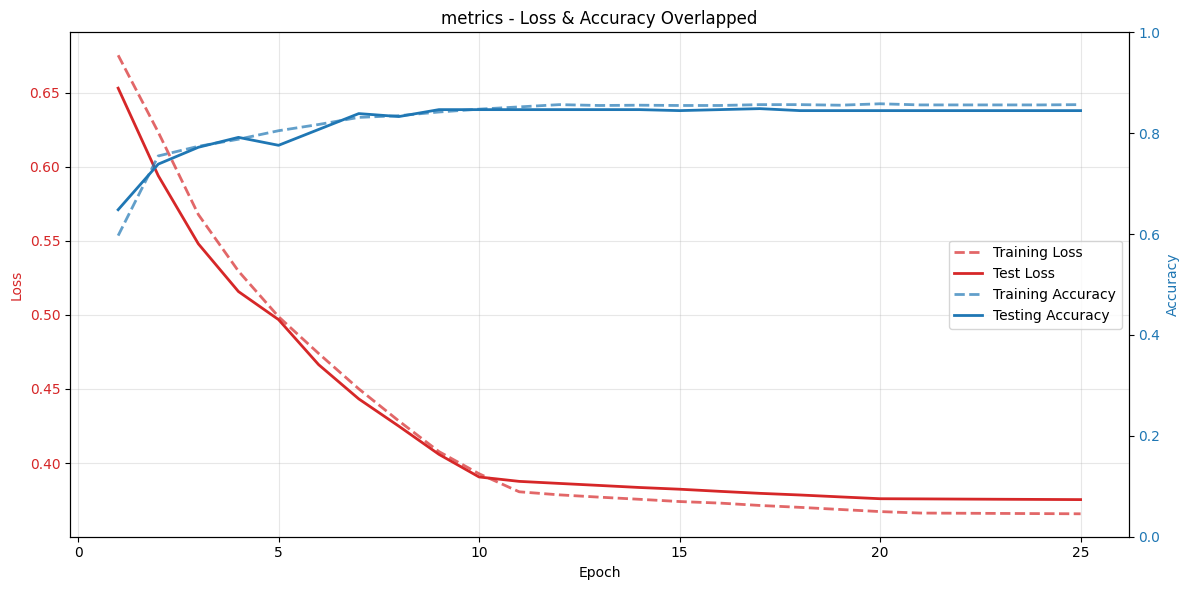


Estadisticas del modelo metrics:
  • Mejor Loss (val): 0.3753
  • Mejor Accuracy (val): 0.8487
  • Épocas entrenadas: 25


In [9]:
# ============================================
# 📊 Importaciones necesarias para visualización
# ============================================

# Importa las funciones oficiales del repo
from plot_functions import (load_training_data, get_model_name_from_path, plot_training_metrics, plot_multiple_models, plot_overlapped_metrics, plot_models_from_directory, plot_current_experiment)

def plot_overlapped_metrics(json_path, figsize=(10, 6), save_path=None):
    """
    Plotea Loss y Accuracy superpuestos en el mismo gráfico.

    Args:
        json_path (str): Ruta al archivo JSON con métricas
        figsize (tuple): Tamaño de la figura
        save_path (str, optional): Ruta para guardar la figura
    """
    # Cargar datos
    data = load_training_data(json_path)
    model_name = get_model_name_from_path(json_path)

    # Preparar datos
    epochs = range(1, len(data['train_losses']) + 1)

    # Crear figura con dos ejes Y
    fig, ax1 = plt.subplots(figsize=figsize)

    # Plot Loss (eje izquierdo)
    color1 = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color1)
    line1 = ax1.plot(epochs, data['train_losses'], '--', color=color1,
                     label='Training Loss', linewidth=2, alpha=0.7)
    line2 = ax1.plot(epochs, data['test_losses'], '-', color=color1,
                     label='Test Loss', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    # Crear segundo eje Y para Accuracy
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color2)
    line3 = ax2.plot(epochs, data['train_accs'], '--', color=color2,
                     label='Training Accuracy', linewidth=2, alpha=0.7)
    line4 = ax2.plot(epochs, data['test_accs'], '-', color=color2,
                     label='Testing Accuracy', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(0, 1)

    # Combinar leyendas
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')

    plt.title(f'{model_name} - Loss & Accuracy Overlapped')
    plt.tight_layout()

    # Guardar si se especifica
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figura guardada en: {save_path}")

    plt.show()

    # Mostrar estadísticas
    print(f"\nEstadisticas del modelo {model_name}:")
    print(f"  • Mejor Loss (val): {min(data['test_losses']):.4f}")
    print(f"  • Mejor Accuracy (val): {max(data['test_accs']):.4f}")
    print(f"  • Épocas entrenadas: {len(epochs)}")

# Ejemplo de uso (ajustar ruta según tu estructura):
metrics_json = os.path.join(config["model_dir"], "metrics.json")
plot_overlapped_metrics(metrics_json, figsize=(12, 6))


## 📊 Evaluación sobre el Conjunto de Test

Tras el entrenamiento, evaluamos el modelo sobre el conjunto de *test* (si existe) y calculamos métricas cuantitativas:

- **Accuracy general**
- **Precisión**, **recall** y **F1-score** (promedio ponderado)
- **Matriz de confusión**

La evaluación queda registrada en un archivo `test_metrics.json` y se genera una figura `confusion_matrix.png` en el directorio de la corrida.


In [10]:
# 📊 Evaluación del modelo (Test y/o Val)
def evaluate_model(model: nn.Module, dataloader, class_names, device, model_dir, split_name="test"):
    """
    Evalúa el modelo sobre un dataloader y guarda:
    - accuracy, precision, recall, F1
    - test_metrics.json o val_metrics.json
    - confusion_matrix_test.png o confusion_matrix_val.png
    """

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Métricas
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    metrics = {
        'accuracy': acc,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1
    }

    # Guardar JSON
    metrics_path = os.path.join(model_dir, f"{split_name}_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"✅ Métricas de {split_name} guardadas en {metrics_path}")
    print(f"🎯 {split_name.upper()} Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # Matriz de confusión
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=range(len(class_names)),
        yticks=range(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicciones",
        ylabel="Etiqueta real",
        title=f"Matriz de confusión ({split_name})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    fig.tight_layout()
    cm_path = os.path.join(model_dir, f"confusion_matrix_{split_name}.png")
    plt.savefig(cm_path)
    plt.close()

    print(f"📊 Matriz de confusión guardada en {cm_path}")
    return metrics


# ==========================================================
# ▶️ EVALUACIÓN FINAL (ahora con TEST + VALIDACIÓN si existen)
# ==========================================================

test_metrics = None
val_metrics = None

# Evaluar VALIDACIÓN real (final)
if 'val' in dataloaders and dataset_sizes.get('val', 0) > 0:
    print("🎯 Evaluando en conjunto de VALIDACIÓN...")
    val_metrics = evaluate_model(
        model_hybrid,
        dataloaders['val'],
        class_names,
        device,
        config['model_dir'],
        split_name="val"
    )
else:
    print("ℹ️ No existe conjunto de validación definido.")

# Evaluar TEST (si existe, depende de tu split)
if 'test' in dataloaders and dataset_sizes.get('test', 0) > 0:
    print("🎯 Evaluando en conjunto de TEST...")
    test_metrics = evaluate_model(
        model_hybrid,
        dataloaders['test'],
        class_names,
        device,
        config['model_dir'],
        split_name="test"
    )
else:
    print("ℹ️ No existe conjunto de test definido.")


🎯 Evaluando en conjunto de VALIDACIÓN...
✅ Métricas de val guardadas en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/val_metrics.json
🎯 VAL Accuracy: 0.8150 | F1: 0.8149
📊 Matriz de confusión guardada en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/confusion_matrix_val.png
🎯 Evaluando en conjunto de TEST...
✅ Métricas de test guardadas en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/test_metrics.json
🎯 TEST Accuracy: 0.8448 | F1: 0.8448
📊 Matriz de confusión guardada en /content/drive/MyDrive/CREMAD/Models/emb_resnet18/emb_resnet18_classic/run_11-15_21-05-36/confusion_matrix_test.png


## ✅ Conclusiones y Próximos Pasos

Este cuaderno presenta una pipeline completa para la clasificación de emociones en el dataset CREMA-D utilizando modelos clásicos y cuánticos.  
Las mejoras implementadas incluyen:

- **Gestión automática de hiperparámetros** y guardado de configuración en JSON.
- **Organización de directorios de salida** por modelo y tipo (clásico/cuántico) con un identificador de corrida.
- **Funciones de carga de datos** que soportan imágenes, embeddings y MFCCs, con filtro de clases.
- **Arquitecturas modulares** que permiten seleccionar entre redes preentrenadas, CNN personalizadas y capas cuánticas.
- **Entrenamiento con registro de curvas** de pérdida y precisión, y guardado de mejores pesos.
- **Evaluación en el conjunto de test** con métricas estándar y matriz de confusión.

Puedes continuar experimentando modificando `base_model`, activando o desactivando la capa cuántica, ajustando `n_qubits` y `q_depth`, o filtrando un subconjunto de emociones mediante `selected_classes`.  
Recuerda revisar el directorio `Models/` en tu Drive para explorar los resultados guardados de cada ejecución.

---

### 🔁 Sección Deprecada / Legacy

A continuación se incluyen algunas funciones y celdas del cuaderno original que ya no forman parte del flujo principal pero se mantienen por referencia histórica. Puedes consultar su código para entender versiones anteriores o para reutilizar fragmentos en otros contextos. *No influyen en la ejecución actual.*


In [11]:
# ❗ Deprecated: Código heredado

# # Función mejorada para crear dataloaders
# def create_dataloaders_enhanced(data_dir, batch_size=8, shuffle=True, num_workers=4, grayscale=False, force_three_channels=False):
#     """
#     Crea dataloaders con análisis detallado de clases.
#
#     Args:
#         data_dir: Directorio con subcarpetas 'train' y 'val'
#         batch_size: Tamaño del batch
#         shuffle: Mezclar datos de entrenamiento
#         num_workers: Número de workers para DataLoader
#         grayscale: Convertir a escala de grises
#         force_three_channels: Si True, duplica canal gris a 3 canales
#
#     Returns:
#         dataloaders, dataset_sizes, class_names, counts_per_class
#     """
#     # Estadísticas de normalización
#     if grayscale and not force_three_channels:
#         mean, std = [0.5], [0.5]
#     else:
#         mean = [0.485, 0.456, 0.406]
#         std = [0.229, 0.224, 0.225]
#
#     # Pipeline de transformaciones
#     transform_list = [transforms.Resize((224, 224))]
#     if grayscale:
#         # Si usamos backbones preentrenados, repetimos el canal a 3
#         if force_three_channels:
#             transform_list.append(transforms.Grayscale(num_output_channels=3))
#         else:
#             transform_list.append(transforms.Grayscale(num_output_channels=1))
#     transform_list += [
#         transforms.ToTensor(),
#         transforms.Normalize(mean, std)
#     ]
#     data_transform = transforms.Compose(transform_list)
#
#     # Crear datasets
#     image_datasets = {
#         phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=data_transform)
#         for phase in ['train', 'val']
#     }
#
#     # Crear dataloaders
#     dataloaders = {
#         phase: DataLoader(
#             image_datasets[phase],
#             batch_size=batch_size,
#             shuffle=(shuffle if phase == 'train' else False),
#             num_workers=num_workers
#         )
#         for phase in ['train', 'val']
#     }
#
#     # Información del dataset
#     dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
#     class_names = image_datasets['train'].classes
#
#     # Conteo por clase
#     counts_per_class = {
#         phase: count_images_per_class_from_dataset(image_datasets[phase], class_names)
#         for phase in ['train', 'val']
#     }
#
#     return dataloaders, dataset_sizes, class_names, counts_per_class
#
# print("✅ Función de carga de datos definida")
#